In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin
from flask import Flask, request, jsonify

In [2]:
# reading the dataset and creating train and test data
df= pd.read_csv("Loan dataset_classification.csv")

df = df.dropna(subset=["Loan_Status"])

# X = df.drop(columns=["Loan_Status","Loan_ID","Gender","Dependents"], axis=1)
X = df.drop(["Loan_Status", "Loan_ID", "Gender", "Dependents"], axis=1)

y = df["Loan_Status"].map({"Y":1,"N":0})
print(y.shape)
print(y.isna().sum())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

(614,)
0


In [3]:
print(y.info())

<class 'pandas.core.series.Series'>
Index: 614 entries, 0 to 613
Series name: Loan_Status
Non-Null Count  Dtype
--------------  -----
614 non-null    int64
dtypes: int64(1)
memory usage: 9.6 KB
None


In [4]:
# deciding all the columns which are getting used for prediction

log_cols = ["ApplicantIncome", "CoapplicantIncome"] 
num_cols = [ "LoanAmount", "Credit_History","Loan_Amount_Term"]
cat_cols = [ "Married", "Self_Employed","Education","Property_Area"]

In [5]:
# Creating pipelines 
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

log_numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("log", FunctionTransformer(np.log1p, validate=False)),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

In [6]:
# Applying pipeline on the model dataset
preprocessor = ColumnTransformer([
    ("log_num", log_numeric_pipeline, log_cols),
    ("num", numeric_pipeline, num_cols),
    ("cat", categorical_pipeline, cat_cols)
])

# class DatasetValidator(BaseEstimator, TransformerMixin):

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         amount_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

#         if (X[amount_cols] < 0).any().any():
#             raise ValueError("Negative values found in amount columns")

#         return X


model_pipeline = Pipeline([
    #("credit_history_validation", DatasetValidator()),
    ("preprocess", preprocessor),
    ("model", LogisticRegression(class_weight="balanced",max_iter=3000))
])

Accuracy: 0.7317073170731707


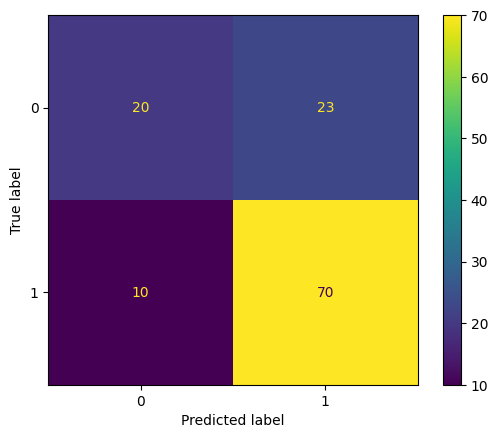

In [7]:
# training the model
model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [8]:
print(preprocessor)

ColumnTransformer(transformers=[('log_num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>)),
                                                 ('scaler', StandardScaler())]),
                                 ['ApplicantIncome', 'CoapplicantIncome']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['LoanAmount', 'Credit_History',
                                  'Loan_Amount_Term']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
            

In [9]:
# app = Flask(__name__)

# @app.route("/data", methods=["GET"])

# def display_csv():
#     # Read CSV
#     df = pd.read_csv("Loan dataset_classification.csv")

#     # Convert DataFrame to HTML table
#     html_table = df.to_html(index=False, border=1)

#     return f"""
#     <html>
#         <head>
#             <title>CSV Data</title>
#         </head>
#         <body>
#             <h2>Loan Dataset</h2>
#             {html_table}
#         </body>
#     </html>
#     """

# @app.route("/predict", methods=["POST"])

# def predict():
#     # below code is for body json
#     data = request.get_json()
#     # data = {
#     #     "ApplicantIncome": float(request.args.get("ApplicantIncome")),
#     #     "CoapplicantIncome": float(request.args.get("CoapplicantIncome")),
#     #     "LoanAmount": float(request.args.get("LoanAmount")),
#     #     "Loan_Amount_Term": int(request.args.get("Loan_Amount_Term")),
#     #     "Credit_History": int(request.args.get("Credit_History")),
#     #     "Married": request.args.get("Married"),
#     #     "Education": request.args.get("Education"),
#     #     "Self_Employed": request.args.get("Self_Employed"),
#     #     "Property_Area": request.args.get("Property_Area")
#     # }
#     df= pd.DataFrame(data, index=[0])
#     prediction = model_pipeline.predict(df)
#     print(prediction)
#     return jsonify({       
#         "predicted_output": int(prediction[0])
#     })
# app.run(port=5000, debug=False, use_reloader=False)

In [10]:
new_data = pd.DataFrame([{
    # 'Gender': 'Male',
    'Married': 'Yes',
    #'Dependents': '1',
    'Education': 'Graduate',
    'Self_Employed': 'No',
    'ApplicantIncome': 5000,
    'CoapplicantIncome': 1500,
    'LoanAmount': 120,
    'Loan_Amount_Term': 360,
    'Credit_History': 1,
    'Property_Area': 'Urban'
}])

def validate_amounts(df):
    amount_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
    for col in amount_cols:
        if (df[col] < 0).any():
            raise ValueError(f"{col} cannot have negative values")

validate_amounts(new_data)


prediction = model_pipeline.predict(new_data)
print("Predicted Loan Status:", prediction)

Predicted Loan Status: [1]


In [11]:
model_pipeline.predict_proba(new_data)

array([[0.24908354, 0.75091646]])

In [12]:
import joblib

# Save the model
joblib.dump(model_pipeline, "iris_rf_model.pkl")
print("Model saved successfully!")

Model saved successfully!


In [13]:
import joblib

model = joblib.load("iris_rf_model.pkl")

# Example input: [sepal_length, sepal_width, petal_length, petal_width]

prediction = model.predict(new_data)
print(prediction)


[1]
